In [1]:
import pandas as pd
import numpy as np
from rdkit import DataStructs, Chem
from pred import CatLgKPredictor
from rdkit.Chem import AllChem
from rdkit.Chem.Descriptors import ExactMolWt

model = CatLgKPredictor('./mymodel')

In [2]:
from collections import Counter
from rdkit.Contrib.SA_Score import sascorer

data = pd.read_csv("logK.csv")

def check_molecule(smiles):
    # Разрешенные элементы и элементы для подсчета атомов
    allowed_elements = {'C', 'H', 'O', 'N', 'P', 'S'}
    count_elements = {'O', 'N', 'P', 'S'}

    # Счетчик элементов в молекуле
    elements_counter = Counter()
    temp_element = '' # Временная переменная для хранения элементов более одного символа

    for char in smiles:
        if char.isalpha():
            # Проверяем, является ли элемент двухбуквенным (например, Cl) - не применимо к данным элементам, но полезно для общности
            if temp_element:
                # Предыдущий элемент был начат, завершаем его
                elements_counter[temp_element] += 1
                temp_element = ''
            if char.isupper():
                # Начало нового элемента
                elements_counter[char] += 1
            else:
                # Продолжение текущего элемента
                temp_element += char
        elif temp_element:
            # Если был накоплен временный элемент, добавляем его в счетчик
            elements_counter[temp_element] += 1
            temp_element = '' # Сброс временного элемента

    # Проверяем, входит ли последний элемент в счетчик, если цикл завершился на букве
    if temp_element:
        elements_counter[temp_element] += 1

    # Проверка условий
    # 1. Все элементы в молекуле должны быть из разрешенного списка
    if not all(element in allowed_elements for element in elements_counter):
        print('# 1. Все элементы в молекуле должны быть из разрешенного списка')
        return False

    # 2. Молекула должна включать не менее трех разных элементов из списка
    if sum(element in allowed_elements for element in elements_counter) < 3:
        print('# 2. Молекула должна включать не менее трех разных элементов из списка')
        return False

    # 3. Суммарно не более 12 атомов элементов O, N, P, S
    if sum(count for element, count in elements_counter.items() if element in count_elements) > 12:
        print('# 3. Суммарно не более 12 атомов элементов O, N, P, S')
        return False
    
    if smiles in data["smiles"].tolist():
      return True

    weight = ExactMolWt(Chem.MolFromSmiles(smiles))
    if weight > 500: 
        print('Вес: ', weight)
        return False

    if sascorer.calculateScore(Chem.MolFromSmiles(smiles))>5: 
        print('Sas > 5', sascorer.calculateScore(Chem.MolFromSmiles(smiles)))
        return False
        

    return True

# Тестирование функции на нескольких молекулах из датасета


In [3]:
gosha_smiles = ['O=P(O)CCP(=O)(O)CN1CCN(C(=O)O)CCN(C(=O)O)CCN(C(=O)O)CC1', 'O=C(O)CCP(=O)(O)CN1CCN(C(=O)O)CCN(C(=O)O)CCN(C(=O)O)CC1', 'NC1=CC=C(CP(=O)(O)CN2CCN(C(=O)O)CCN(C(=O)O)CCN(C(=O)O)CC2)C=C1', 'O=P(O)(O)CN1CCN(C(=O)O)CCN(C(=O)O)CCN(C(=O)O)CC1', 'O=C(O)N1CCN(CP(=O)(O)O)CCN(C(=O)O)CCN(C(=O)O)CC1', 'OCP(=O)(O)CN1CCN(C(=O)O)CCN(C(=O)O)CCN(C(=O)O)CC1', 'O=P(O)(O)CN(CC1=CC=CC(CN(CP(=O)(O)O)CP(=O)(O)O)=N1)CP(=O)(O)O', 'NC=CCP(=O)(O)CN1CCN(C(=O)O)CCN(C(=O)O)CCN(C(=O)O)CC1']
gosha_smiles += ['O=P(O)(O)CN(CC1=CC=CC(CN(CP(=O)(O)O)CP(=O)(O)O)=N1)CP(=O)(O)O', 'O=P(O)CCP(=O)(O)CN1CCN(C(=O)O)CCN(C(=O)O)CCN(C(=O)O)CC1', 'O=P(O)(O)CN1CCN(C(=O)O)CCN(C(=O)O)CCN(C(=O)O)CC1', 'O=C(O)N1CCN(CP(=O)(O)O)CCN(C(=O)O)CCN(C(=O)O)CC1', 'OCCP(=O)(O)CN1CCN(C(=O)O)CCN(C(=O)O)CCN(C(=O)O)CC1']

In [4]:
gosha_sub = pd.DataFrame({'smiles': gosha_smiles, 'lgK': model.predict_lgK(pd.DataFrame({'smiles': gosha_smiles}))})
gosha_sub.head(2)

,smiles,lgK
0,O=P(O)CCP(=O)(O)CN1CCN(C(=O)O)CCN(C(=O)O)CCN(C...,26.144873
1,O=C(O)CCP(=O)(O)CN1CCN(C(=O)O)CCN(C(=O)O)CCN(C...,25.385081


In [5]:
gosha_sub.to_csv('./gosha_sub.csv', index=False)

In [6]:
def eblan_concan(sub1: pd.DataFrame, sub2: pd.DataFrame, check_sim: bool, check_validity = bool):
    sub1 = sub1.reset_index(drop=True)
    sub2 = sub2.reset_index(drop=True)
    #sub1["lgK"] = model.predict_lgK(sub1.reset_index(drop=True))
    #sub2["lgK"] = model.predict_lgK(sub2.reset_index(drop=True))
    all_subs = pd.concat([sub1, sub2])
    all_subs = all_subs.drop_duplicates(subset=['smiles'])
    all_subs = all_subs.reset_index(drop=True)
    
    can_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(m), isomericSmiles=True, canonical=True) for m in all_subs.smiles.tolist()]

    all_subs = pd.DataFrame({'smiles': list(set(can_smiles))})
    
    all_subs['lgK'] = model.predict_lgK(all_subs[['smiles']].reset_index(drop=True))
    if check_sim:
        ms = [Chem.MolFromSmiles(sm) for sm in all_subs['smiles']]
        fpgen = AllChem.GetRDKitFPGenerator()
        fps = [fpgen.GetFingerprint(x) for x in ms]
        for i in range(len(fps)):
            for j in range(i+1, len(fps)):
                try:
                    if DataStructs.TanimotoSimilarity(fps[i], fps[j]) > 0.5:
                        if all_subs["lgk"][i]>=all_subs["lgk"][j]:# and all_subs["lgk"][j]<(all_subs['lgk'].mean()):
                            all_subs.drop(labels=[j], inplace=True)
                        elif all_subs["lgk"][i]<all_subs["lgk"][j]:# and all_subs["lgk"][i]<(all_subs['lgk'].mean()):
                            all_subs.drop(labels=[i], inplace=True)
                except KeyError:
                    pass
    if check_validity:  
        all_subs = all_subs.loc[[check_molecule(molecule) for molecule in all_subs["smiles"].tolist()]]
        
    return all_subs.sort_values(by="lgK", ascending=False)

In [8]:
def calculate_mean_lgK(df):
    return df['lgK'].sum() / 100

def calculate_real_mean_lgK(df):
    return df['lgK'].mean()

In [9]:
sub1 = pd.read_csv('./generated/invalid_default_c.csv')[['smiles']]
sub2 = pd.read_csv('./generated/invalid_enhanced_c.csv')[['smiles']]
sub3 = pd.read_csv('./BBBEST_SUB.csv', names=['smiles'])
sub4 = pd.read_csv('./generated/semivalid_enhanced.csv')

In [10]:
bbbest = pd.read_csv(r'C:\Users\user\Downloads\Archive\generated\pppppooooo.csv')
bbbest.head()

,smiles,lgk
0,CP(O)CN1CCN(C(=O)O)CCN(C(=O)O)CCN(C(=O)O)CC1,24.434994
1,O=C(O)CN1CCN(CC(=O)O)CCN(CC(=O)O)CCN(CC(=O)O)CC1,23.664383
2,O=C(O)CN1CCN(CCO)CCN(CC(=O)O)CCN(CC(=O)O)CC1,23.185349
3,O=CC(O)CN1CCN(C(=O)O)CCN(C(=O)O)CCN(C(=O)O)CC1,23.148795
4,O=C(O)N1CCN(C[CH+](=O)O)CCN(C(=O)O)CCN(C(=O)O)CC1,22.855576


In [11]:
sub1.head(2), sub3.head(2)

(                                              smiles
 0  O=P(O)(O)CN(Cc1cccc(CN(CP(=O)(O)O)CP(=O)(O)O)n...
 1   O=C(O)N1CCN(CP(=O)(O)O)CCN(C(=O)O)CCN(C(=O)O)CC1,
                                              smiles
 0  O=C(O)CN1CCN(CC(=O)O)CCN(CC(=O)O)CCN(CC(=O)O)CC1
 1      O=C(O)CN1CCN(CCO)CCN(CC(=O)O)CCN(CC(=O)O)CC1)

### Без проверки на валидность

In [16]:
best_sub = pd.read_csv('./subs/sub_23.623961401355377.csv', names=['smiles'])
best_sub['lgK'] = model.predict_lgK(best_sub)

In [17]:
concat12 = eblan_concan(sub1=best_sub, sub2=sub1, check_sim=True, check_validity=False)

calculate_mean_lgK(concat12)

16.213943475061548

In [18]:
concat12['smiles'].to_csv(f'./subs/sub_{calculate_mean_lgK(concat12)}.csv', index=False, header=None)

In [19]:
concat123 = eblan_concan(bbbest, concat12, check_sim=True, check_validity=True)

calculate_mean_lgK(concat123)

# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 1. Все элементы в молекуле должны быть из разрешенного списка
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 1. Все элементы в молекуле должны быть из разрешенного списка
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 1. Все элементы в молекуле должны быть из разрешенного списк

20.920576920325306

In [20]:
qwe = pd.read_csv(r'C:\Users\user\Downloads\Archive\subs\ssssuuuuupppp (3) (1).csv', names=['smiles'])
qwe['lgK'] = model.predict_lgK(qwe[['smiles']].reset_index(drop=True))
qwe.head()

,smiles,lgK
0,C[PH](O)=CN1CCN(C(=O)O)CCN(C(=O)O)CCN(C(=O)O)CC1,24.397212
1,C=[P@H](O)N1CCN(C(=O)O)CCN(C(=O)O)CCN(C(=O)O)CC1,24.372936
2,CP(O)[CH]N1CCN(C(=O)O)CCN(C(=O)O)CCN(C(=O)O)CC1,24.191714
3,O=C(O)CN1CCN(CC(=O)O)CCN(CC(=O)O)CCN(CC(=O)O)CC1,23.664383
4,C=S(O)CN1CCN(C(=O)O)CCN(C(=O)O)CCN(C(=O)O)CC1,23.649958


In [21]:
qwe.to_csv('./generated/qwe.csv', index=False)

In [22]:
len(concat123)

100

In [23]:
concat123['smiles'].to_csv(f'./subs/subasd_{calculate_mean_lgK(concat123)}.csv', index=False, header=None)

In [24]:
concat1234 = eblan_concan(sub1=concat123, sub2=sub4, check_sim=True, check_validity=True)

calculate_mean_lgK(concat1234)

# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S


22.017145380259972

In [25]:
gosha_concat = eblan_concan(sub1=gosha_sub, sub2=concat1234, check_sim=True, check_validity=False)

calculate_mean_lgK(gosha_concat)

24.13132202776932

#### Проход по всем файлам

In [26]:
import os

t = 0

for p in os.listdir('./generated/'):
    
    path = './generated/' + p
    cur_sub = pd.read_csv(path)
    if t == 0:
        cur_concat = eblan_concan(gosha_concat, cur_sub, check_sim=True, check_validity=False)
    cur_concat = eblan_concan(cur_concat, cur_sub, True, False)
    print('Name:', p, 'lgK / 100:', calculate_mean_lgK(cur_sub), 'mean lgK', calculate_real_mean_lgK(cur_sub))
    print(calculate_mean_lgK(cur_concat))
    
    t += 1

Name: fin_pop.csv lgK / 100: 2.081646654614642 mean lgK 26.020583182683026
25.1009623297584
Name: fin_pop1.csv lgK / 100: 1.6397055100675173 mean lgK 27.328425167791952
25.1009623297584
Name: fin_pop2.csv lgK / 100: 2.795601790829649 mean lgK 25.414561734814992
25.80731954312017
Name: invalid_default_c.csv lgK / 100: 16.213943475061548 mean lgK 23.498468804437024
39.02218569685808
Name: invalid_default_c_23.48479313572707.csv lgK / 100: 16.90905105772349 mean lgK 23.48479313572707
48.29582569650432
Name: invalid_default_c_23.58200692641602.csv lgK / 100: 16.27158477922705 mean lgK 23.582006926416017
57.32749445816115
Name: invalid_default_c_23.634702728994807.csv lgK / 100: 7.5631048732783395 mean lgK 23.63470272899481
59.54194960136556
Name: invalid_default_c_23.64055734826607.csv lgK / 100: 13.71152326199432 mean lgK 23.640557348266068
63.66146760186912
Name: invalid_default_c_24.456760033080954.csv lgK / 100: 3.6685140049621427 mean lgK 24.456760033080954
65.07717431066854
Name: inv

In [27]:
cur_concat.iloc[:len(cur_concat)//2].to_csv('./data_to_razduplit_1.csv', index=False)
cur_concat.iloc[len(cur_concat)//2:].to_csv('./data_to_razduplit_2.csv', index=False)

In [54]:
cur_concat['smiles'].to_csv(f'./subs/concat_{cur_concat["lgK"].mean()}.csv', index=False, header=None)

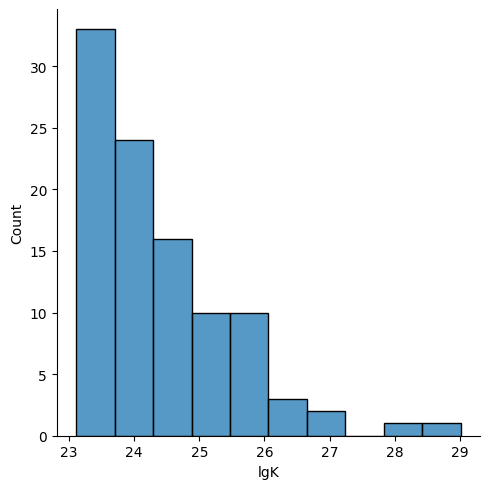

In [55]:
import seaborn as sns

sns.displot(cur_concat['lgK'])

In [56]:
cur_concat

,smiles,lgK
210,O=P(O)(O)CN(Cc1cccc(CN(CP(=O)(O)O)CP(=O)(O)O)n...,29.016023
159,O=C(O)N1CCN(CP(=O)(O)O)CCN(C(=O)O)CCN(C(=O)O)CC1,28.399766
133,N=P(O)(O)CN1CCN(C(=O)O)CCN(C(=O)O)CCN(C(=O)O)CC1,27.039173
73,O=C(O)N1CCN(CS(O)(O)O)CCN(C(=O)O)CCN(C(=O)O)CC1,26.844821
48,O=C(O)N1CCN(CP(=O)(O)CCO)CCN(C(=O)O)CCN(C(=O)O...,26.625043
...,...,...
191,O=C(O)CN1CCN(CCCO)CCN(CC(=O)O)CCN(CC(=O)O)CC1,23.160379
18,CC(O)N1CCN(C(=O)O)CCN(CP(=O)(O)O)CCN(C(=O)O)CC1,23.151837
203,CC(O)N1CCN(CP(=O)(O)O)CCN(C(=O)O)CCN(C(=O)O)CC1,23.129807
104,O=C(O)Nc1ccc(CP(=O)(O)CN2CCN(C(=O)O)CCN(C(=O)O...,23.115494


### С проверкой на валидность

In [64]:
concat1234_valid = eblan_concan(sub3, gosha_concat, check_sim=True, check_validity=True)

calculate_mean_lgK(concat1234_valid)

# 1. Все элементы в молекуле должны быть из разрешенного списка
# 1. Все элементы в молекуле должны быть из разрешенного списка
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 1. Все элементы в молекуле должны быть из разрешенного списка
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 1. Все элементы в молекуле должны быть из разрешенного списка
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 1. Все элементы в молекуле должны быть из разрешенного списка
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 1. Все элементы в молекуле должны быть из разрешенного списка
# 3. Суммарно не более

20.641645762402277

In [66]:
concat1234_valid['smiles'].to_csv('./subs/kkkk.csv', index=False, header=None)

In [59]:
import os

t = 0

cur_val_concat = concat1234_valid

for p in os.listdir('./generated/'):
    
    path = './generated/' + p
    cur_sub = pd.read_csv(path)
    cur_val_concat = eblan_concan(cur_val_concat, cur_sub, True, True)
    
    print(calculate_mean_lgK(cur_val_concat))
    
    t += 1

# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 1. Все элементы в молекуле должны быть из разрешенного списка
# 3. Суммарно не более 12 атомов элементов O, N, P, S
20.641645762402277
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 1. Все элементы в молекуле должны быть из разрешенного списка
20.641645762402277
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 12 атомов элементов O, N, P, S
# 3. Суммарно не более 1

In [60]:
cur_val_concat

,smiles,lgK
89,O=C(O)CN1CCN(CC(=O)O)CCN(CC(=O)O)CCN(CC(=O)O)CC1,23.664383
16,O=C(O)CN1CCN(CCO)CCN(CC(=O)O)CCN(CC(=O)O)CC1,23.185349
194,O=C(O)CN1CCN(CCCO)CCN(CC(=O)O)CCN(CC(=O)O)CC1,23.160379
22,O=C(O)CN1CCN(C(=O)O)CCN(C(=O)O)CCN(C(=O)O)CC1,22.806817
54,O=C(O)CN1CCN(CC(=O)O)CCN(C(=O)O)CCN(CC(=O)O)CC1,22.645275
...,...,...
48,O=C(O)CN1[CH-]CN(CC(=O)O)CCN(CC(=O)O)CCN(CCCO)CC1,19.592779
71,O=C(O)CN1[CH-]CN(CCCO)CCN(CC(=O)O)CCN(CC(=O)O)CC1,19.582868
176,O=C(O)[CH-]N1CCN(CC(=O)O)CCN(CC(=O)O)CCN(CC(=O...,19.576134
230,O=C(O)CN(CCN(CC(=O)O)CC(=O)O)CC(=O)O,19.555879


In [62]:
cur_val_concat['smiles'].to_csv(f'./subs/concat_{cur_val_concat["lgK"].mean()}.csv', index=False, header=None)

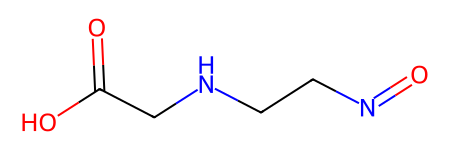

In [20]:
tt_smiles = ['O=NCCNCC(=O)O']
for sm in tt_smiles:
    display(Chem.MolFromSmiles(sm))